## Converts .eeg file to pandas dataframe

In [ ]:
import numpy as np
import struct

def eeg_to_ascii(file_name, chanlist='all', triallist='all', typerange='all', accepttype='all', rtrange='all', responsetype='all', data_format='auto'):
    with open(file_name, 'rb') as f:
        # Read general part of the ERP header and set variables
        f.read(20) # skip revision number
        f.read(342) # skip the first 362 bytes

        nsweeps = struct.unpack('<H', f.read(2))[0] # number of sweeps
        f.read(4) # skip 4 bytes
        pnts = struct.unpack('<H', f.read(2))[0] # number of points per waveform
        chan = struct.unpack('<H', f.read(2))[0] # number of channels
        f.read(4) # skip 4 bytes
        rate = struct.unpack('<H', f.read(2))[0] # sample rate (Hz)
        f.read(127) # skip 127 bytes
        xmin = struct.unpack('<f', f.read(4))[0] # in s
        xmax = struct.unpack('<f', f.read(4))[0] # in s
        f.read(387) # skip 387 bytes

        # Read electrode configuration
        chan_names = []
        baselines = []
        sensitivities = []
        calibs = []
        factors = []
        for elec in range(chan):
            chan_name = f.read(10).decode('ascii').strip('\x00')
            chan_names.append(chan_name)
            f.read(37) # skip 37 bytes
            baseline = struct.unpack('<H', f.read(2))[0]
            baselines.append(baseline)
            f.read(10) # skip 10 bytes
            sensitivity = struct.unpack('<f', f.read(4))[0]
            sensitivities.append(sensitivity)
            f.read(8) # skip 8 bytes
            calib = struct.unpack('<f', f.read(4))[0]
            calibs.append(calib)
            factor = calib * sensitivity / 204.8
            factors.append(factor)

    # Read and process epoch datapoints data
    data = np.empty((nsweeps, len(chan_names), pnts), dtype=float)
    sweep_headers = []

    # Constants for the sweep header size in bytes and data point size in bytes
    SWEEP_HEAD_SIZE = 13
    DATA_POINT_SIZE = 4

    with open(file_name, 'rb') as f:
        # Ensure the file pointer is at the beginning of the EEG data
        f.seek((900 + chan * 75))

        for sweep in range(nsweeps):
            # Read the sweep header
            f.read(SWEEP_HEAD_SIZE)
            # ttype = struct.unpack('<h', f.read(2))[0]
            # accept = f.read(1)
            # correct = struct.unpack('<h', f.read(2))[0]
            # rt = struct.unpack('<f', f.read(4))[0]
            # response = struct.unpack('<h', f.read(2))[0]
            # #reserved  struct.unpack('<h', f.read(2))[0]
            # sweep_headers.append((ttype, accept, correct, rt, response))

            for point in range(pnts):
                for channel in range(chan):

                    # Read the data point as a 2-byte integer
                    value = struct.unpack('<l', f.read(DATA_POINT_SIZE))[0]

                    # Scale the data point to microvolts and store it in the data array
                    data[sweep, channel, point] = value * factors[channel]

    # Return relevant data in ASCII format (or any other format you'd like)
    
    #Transpose data to have the swap channels and points
    #data = np.transpose(data, (0, 2, 1))
    return data, chan_names, rate

file_name = "/home/woess/current assignment/read_neuro_scratch/16017_rest_ec.eeg"


eeg_data, channels = eeg_to_ascii(file_name)
print("Channels:", channels)
print("EEG data:", eeg_data)

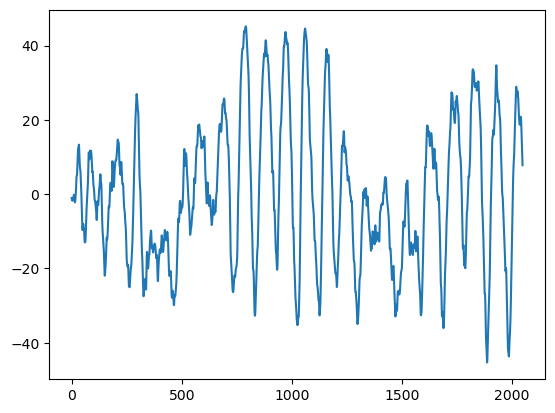

In [19]:
#Place eeg_data into a pandas dataframe
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(eeg_data[0], columns=channels)
#Display all decimals
pd.set_option('display.float_format', lambda x: '%.10f' % x)
#df

#plot the data

plt.plot(df.index.to_list(),df["O2"].to_list())


plt.show()
